In [1]:
%load_ext jupyternotify

# import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
# import timeit


from tqdm.auto import tqdm
# from scipy.stats import *

pd.set_option('display.max_columns', None)

<IPython.core.display.Javascript object>

In [2]:
# pd.set_option('display.max_colwidth', None)

In [180]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
raw_all_df = pd.read_csv('data/PitchData_15-22.csv', index_col=[0])

/Users/honeybunny/opt/anaconda3/envs/pitch_seq/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3256: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [181]:
raw_all_df.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
190,SL,2022-11-05,89.2,-0.06,6.14,"Pressly, Ryan",592206,519151,field_out,hit_into_play,NaN,NaN,NaN,NaN,14.0,Nick Castellanos flies out to right fielder Ky...,W,R,R,HOU,PHI,X,9.0,fly_ball,0,0,2022,0.41,0.37,1.05,2.39,NaN,NaN,592663.0,2,9,Top,195.76,145.13,NaN,NaN,455117.0,NaN,NaN,1.859662,-129.958368,-4.015258,4.329541,25.545818,-27.380437,3.65,1.74,217.0,84.1,53.0,89.2,2679.0,6.1,715719,519151,455117.0,641820.0,514888.0,608324.0,665161.0,670541.0,676801.0,663656.0,54.42,0.020,0.021,0.0,1.0,0.0,0.0,3.0,64,1,Slider,4,1,1,4,1,4,1,4,Standard,Standard,137.0,0.011,-0.219
199,FF,2022-11-05,93.9,-0.18,5.94,"Pressly, Ryan",547180,519151,field_out,hit_into_play,NaN,NaN,NaN,NaN,8.0,Bryce Harper flies out to left fielder Yordan ...,W,L,R,HOU,PHI,X,7.0,fly_ball,0,0,2022,-0.33,1.57,0.06,2.08,NaN,NaN,592663.0,1,9,Top,65.52,124.44,NaN,NaN,455117.0,NaN,NaN,1.368792,-136.486377,-7.693218,-4.423997,32.019240,-11.046260,3.24,1.62,239.0,99.4,60.0,93.6,2512.0,6.3,715719,519151,455117.0,641820.0,514888.0,608324.0,665161.0,670541.0,676801.0,663656.0,54.19,0.020,0.028,0.0,1.0,0.0,0.0,3.0,63,1,4-Seam Fastball,4,1,1,4,1,4,1,4,Infield shift,Standard,210.0,0.022,-0.300
205,FF,2022-11-05,93.0,-0.09,5.97,"Pressly, Ryan",592663,519151,single,hit_into_play,NaN,NaN,NaN,NaN,8.0,J.T. Realmuto singles on a sharp line drive to...,W,R,R,HOU,PHI,X,8.0,line_drive,0,0,2022,-0.20,1.63,0.04,1.57,NaN,NaN,NaN,1,9,Top,124.52,72.33,NaN,NaN,455117.0,NaN,NaN,0.792904,-135.240082,-9.044987,-2.662444,30.778080,-10.405251,3.61,1.67,267.0,105.8,14.0,92.9,2421.0,6.3,715719,519151,455117.0,641820.0,514888.0,608324.0,665161.0,670541.0,676801.0,663656.0,54.15,0.700,0.752,0.9,1.0,1.0,0.0,5.0,62,1,4-Seam Fastball,4,1,1,4,1,4,1,4,Standard,Standard,212.0,-0.020,0.262
222,SL,2022-11-05,88.1,-0.15,6.03,"Pressly, Ryan",656555,519151,field_out,hit_into_play,NaN,NaN,NaN,NaN,14.0,Rhys Hoskins flies out to right fielder Kyle T...,W,R,R,HOU,PHI,X,9.0,fly_ball,1,2,2022,0.61,0.21,0.92,1.43,NaN,NaN,NaN,0,9,Top,168.45,104.25,NaN,NaN,455117.0,NaN,NaN,1.336480,-128.290529,-5.546018,6.571943,24.542605,-28.945025,3.61,1.68,259.0,82.2,44.0,88.4,2798.0,6.2,715719,519151,455117.0,641820.0,514888.0,608324.0,665161.0,670541.0,676801.0,663656.0,54.26,0.011,0.010,0.0,1.0,0.0,0.0,3.0,61,4,Slider,4,1,1,4,1,4,1,4,Infield shift,Standard,120.0,0.018,-0.158
228,SL,2022-11-05,89.0,-0.25,6.06,"Pressly, Ryan",656555,519151,NaN,foul,NaN,NaN,NaN,NaN,8.0,Rhys Hoskins flies out to right fielder Kyle T...,W,R,R,HOU,PHI,S,NaN,NaN,1,1,2022,0.40,0.48,0.11,2.27,NaN,NaN,NaN,0,9,Top,NaN,NaN,NaN,NaN,455117.0,NaN,NaN,0.058103,-129.716040,-4.326569,4.499477,24.912144,-26.114640,3.61,1.68,7.0,81.9,-19.0,89.1,2811.0,6.1,715719,519151,455117.0,641820.0,514888.0,608324.0,665161.0,670541.0,676801.0,663656.0,54.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,Slider,4,1,1,4,1,4,1,4,Infield shift,Standard,121.0,0.000,-0.054


In [5]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
reg_all_df = raw_all_df[raw_all_df['game_type']=='R'].copy()

In [7]:
reg_all_df.reset_index(inplace=True, drop=True)

In [8]:
# create seperate pitch index for later merging opt
reg_all_df.reset_index(inplace=True)
reg_all_df.rename(columns={'index':'pitch_index'}, inplace=True)

In [9]:
reg_all_df['n_count'] = 1

# Visual inspection

In [10]:
# import utils

# reg_all_df = utils.get_vid_link(reg_all_df)

# remove bad PAs
PA that changed pitcher or batter or doesn't contain events

In [11]:
pa_df = reg_all_df.groupby(['game_year', 'game_pk', 'at_bat_number', 'pitcher', 'batter']).agg({
    'events':'first',
    'des':'first',
    'pitch_index':'first'
}).reset_index()
pa_df.head()

,game_year,game_pk,at_bat_number,pitcher,batter,events,des,pitch_index
0,2015,413649,1,433587,594777,strikeout,Kole Calhoun called out on strikes.,5274688
1,2015,413649,2,433587,545361,home_run,Mike Trout homers (1) on a fly ball to center ...,5274680
2,2015,413649,3,433587,405395,strikeout,Albert Pujols strikes out on a foul tip.,5274673
3,2015,413649,4,433587,459964,strikeout,Matt Joyce strikes out swinging.,5274670
4,2015,413649,5,450308,457706,field_out,"Austin Jackson grounds out, shortstop Erick Ay...",5274668


In [12]:
# create df of duplicated pa
pa_dup = pa_df[pa_df.duplicated(subset=['game_pk', 'at_bat_number'], keep='first')]
pa_dup_list = [(x, y) for x, y in zip(pa_dup['game_pk'], pa_dup['at_bat_number'])]

In [13]:
drop_idx = []

for pa in pa_dup_list:
    drop_idx += reg_all_df[(reg_all_df['game_pk']==pa[0])&(reg_all_df['at_bat_number']==pa[1])].index.to_list()

In [14]:
reg_all_df.shape

(5275005, 94)

In [15]:
# drop duplicated PA
reg_all_df.drop(index=drop_idx, inplace=True)

In [16]:
# re-create pa_df
pa_df = reg_all_df.groupby(['game_year', 'game_pk', 'at_bat_number', 'pitcher', 'batter']).agg({
    'events':'first',
    'des':'first',
    'pitch_index':'first'
}).reset_index()
pa_df.head()

,game_year,game_pk,at_bat_number,pitcher,batter,events,des,pitch_index
0,2015,413649,1,433587,594777,strikeout,Kole Calhoun called out on strikes.,5274688
1,2015,413649,2,433587,545361,home_run,Mike Trout homers (1) on a fly ball to center ...,5274680
2,2015,413649,3,433587,405395,strikeout,Albert Pujols strikes out on a foul tip.,5274673
3,2015,413649,4,433587,459964,strikeout,Matt Joyce strikes out swinging.,5274670
4,2015,413649,5,450308,457706,field_out,"Austin Jackson grounds out, shortstop Erick Ay...",5274668


In [17]:
missing_event_df = pa_df[pa_df['events'].isna()].copy()

In [18]:
missing_event_df[missing_event_df['des'].isna()]

,game_year,game_pk,at_bat_number,pitcher,batter,events,des,pitch_index
8453,2015,413759,62,466948,572816,None,None,5243123
14444,2015,413840,22,282332,434658,None,None,5220248
16995,2015,413873,51,112526,592743,None,None,5210438
33041,2015,414086,46,572750,648717,None,None,5151816


In [19]:
# drop pa if des is None
missing_event_df.drop(index=missing_event_df[missing_event_df['des'].isna()].index, inplace=True)

In [20]:
for i, r in missing_event_df.iterrows():
    missing_event_df.loc[i, 'events_imputed'] = 'BB' if 'intentionally walks' in r['des'] else 'other'

In [21]:
reg_all_df.shape

(5272280, 94)

In [22]:
missing_event_df.head()

,game_year,game_pk,at_bat_number,pitcher,batter,events,des,pitch_index,events_imputed
1856,2015,413674,68,449097,452672,None,Ryan Hanigan reaches on catcher interference b...,5267816,other
5082,2015,413716,16,477132,572041,None,"With A. J. Pollock batting, Archie Bradley pi...",5255843,other
6236,2015,413731,4,518567,435062,None,"With Howie Kendrick batting, Jimmy Rollins pic...",5251510,other
6504,2015,413734,38,594987,516416,None,Carlos Gomez picked off and caught stealing 3r...,5250549,other
8798,2015,413764,42,518774,429667,None,Ryan Howard reaches on catcher interference by...,5241841,other


In [23]:
missing_event_df.shape

(1727, 9)

In [24]:
reg_all_df = reg_all_df.merge(missing_event_df[['pitch_index', 'events_imputed']]\
                 , on=['pitch_index'], how='left', suffixes=('', '_y'))

In [25]:
# drop pitches if des is None
reg_all_df.drop(index=reg_all_df[reg_all_df['des'].isna()].index, inplace=True)

In [26]:
reg_all_df.loc[reg_all_df['events'].isna(), 'events'] = reg_all_df['events_imputed']
reg_all_df.reset_index(drop=True, inplace=True)

In [27]:
reg_all_df.shape

(5272267, 95)

# Remove ball 4s

In [28]:
reg_all_df['balls'].value_counts()

0    2377217
1    1570376
2     891515
3     433139
4         20
Name: balls, dtype: int64

In [29]:
reg_all_df['strikes'].value_counts()

0    2122301
1    1608040
2    1541925
3          1
Name: strikes, dtype: int64

In [30]:
reg_all_df[(reg_all_df['balls']==4)].shape

(20, 95)

In [31]:
b4_info = reg_all_df[(reg_all_df['balls']==4)|(reg_all_df['strikes']==3)][['balls', 'strikes', 'game_pk', 'at_bat_number']].drop_duplicates(subset=['game_pk', 'at_bat_number'], keep='first').copy()
b4_info

,balls,strikes,game_pk,at_bat_number
26157,4,2,661097,58
250201,1,3,662725,21
650016,4,2,662390,63
1085773,4,2,633530,44
1438229,4,2,630892,74
2217116,4,1,566783,67
2671331,4,2,530969,66
2997499,4,2,529872,28
3357945,4,2,491781,45
4738467,4,2,415513,4


In [32]:
# remove pa with ball 4

drop_idx = []
for i, r in b4_info.iterrows():
    drop_idx += reg_all_df[(reg_all_df['game_pk']==r[2])&(reg_all_df['at_bat_number']==r[3])].index.to_list()

In [33]:
reg_all_df[(reg_all_df['game_pk']==r[1])&(reg_all_df['at_bat_number']==r[2])].index

Int64Index([], dtype='int64')

In [34]:
reg_clean_df = reg_all_df.drop(index=drop_idx)

In [35]:
#pitches dropped
reg_all_df.shape[0] - reg_clean_df.shape[0]

92

# Player filter

In [36]:
pa_batter = reg_all_df.groupby(['batter', 'game_pk', 'at_bat_number']).agg({'n_count':sum}).reset_index()
pa_batter['n_count'] = 1
pa_batter = pa_batter.groupby('batter').agg({'n_count':sum}).reset_index()
pa_batter.head()

,batter,n_count
0,112526,153
1,115629,1
2,116338,569
3,120074,1241
4,121347,865


In [37]:
pa_batter['n_count'].mean()

567.3006700167505

<AxesSubplot: xlabel='n_count', ylabel='Count'>

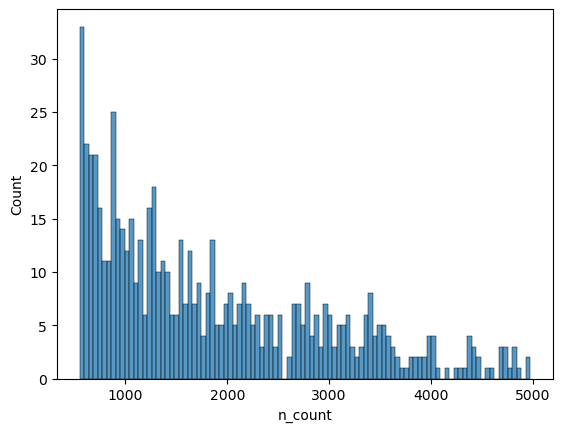

In [38]:
sns.histplot(data=pa_batter[pa_batter['n_count']>=550], x='n_count', bins=100)

In [39]:
pa_batter[pa_batter['n_count']>=550].shape

(649, 2)

In [40]:
pa_pitcher = reg_all_df.groupby(['pitcher', 'game_pk', 'at_bat_number']).agg({'n_count':sum}).reset_index()
pa_pitcher['n_count'] = 1
pa_pitcher = pa_pitcher.groupby(['pitcher']).agg({'n_count':sum}).reset_index().copy()

In [41]:
pa_pitcher['n_count'].mean()

654.4512077294686

In [42]:
pa_pitcher[pa_pitcher['n_count']>=650].shape

(625, 2)

## Create player filter

In [43]:
batter_quali_list = pa_batter[pa_batter['n_count']>=550]['batter'].to_list()
len(batter_quali_list)

649

In [44]:
pitcher_quali_list = pa_pitcher[pa_pitcher['n_count']>=650]['pitcher'].to_list()
len(pitcher_quali_list)

625

# Create event_type

In [45]:
B1_list = 'single'
B2_list = 'double'
B3_list = 'triple'
HR_list = 'home_run'
FO_list = ['field_out', 'grounded_into_double_play', 'sac_bunt', 'force_out', 'field_error', 
            'sac_fly', 'double_play', 'fielders_choice', 'fielders_choice_out', 'sac_fly_double_play',
           'sac_bunt_double_play', 'triple_play']
K_list = ['strikeout', 'strikeout_double_play']
BB_list = ['walk','hit_by_pitch', 'intent_walk', 'BB']
other_list = ['caught_stealing_2b', 'caught_stealing_home','other_out', 'pickoff_3b', 'catcher_interf', 
              'caught_stealing_3b', 'wild_pitch', 'passed_ball', 'stolen_base_2b', 'pickoff_2b', 
              'pickoff_1b', 'pickoff_caught_stealing_2b', 'game_advisory', 'pickoff_caught_stealing_3b',
              'pickoff_caught_stealing_home', 'runner_double_play', 'other', 'stolen_base_home',
             'pickoff_error_2b', 'ejection', 'pickoff_error_2b', 'stolen_base_3b']

In [46]:
# check if any events are not counted
e_list = reg_clean_df['events'].unique()
[e for e in e_list if e not in FO_list + K_list + BB_list + other_list \
 + [B1_list] + [B2_list] + [B3_list] + [HR_list]]

[nan]

In [47]:
reg_clean_df.loc[reg_clean_df['events']=='single', 'event_type'] = '1B'
reg_clean_df.loc[reg_clean_df['events']=='double', 'event_type'] = '2B'
reg_clean_df.loc[reg_clean_df['events']=='triple', 'event_type'] = '3B'
reg_clean_df.loc[reg_clean_df['events']=='home_run', 'event_type'] = 'HR'
reg_clean_df.loc[reg_clean_df['events'].isin(FO_list), 'event_type'] = 'FO'
reg_clean_df.loc[reg_clean_df['events'].isin(K_list), 'event_type'] = 'K'
reg_clean_df.loc[reg_clean_df['events'].isin(BB_list), 'event_type'] = 'BB'
reg_clean_df.loc[reg_clean_df['events'].isin(other_list), 'event_type'] = 'other'

In [48]:
b_count_list = [0, 1, 2, 3]
s_count_list = [0,1,2]
event_list = ['1B', '2B', '3B', 'HR', 'FO', 'BB', 'K', 'other']

count_list = [(b, s) for s in s_count_list for b in b_count_list]

count_list

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (0, 2),
 (1, 2),
 (2, 2),
 (3, 2)]

# Calculate player transition matrix

In [49]:
def get_player_T(player_id, is_pitcher=False):
    
    if is_pitcher:
        player_df = reg_clean_df[reg_clean_df['pitcher']==player_id].copy()
        if player_df.empty:
            raise Exception("player_id not found as pitcher")
    else:
        player_df = reg_clean_df[reg_clean_df['batter']==player_id].copy()
        if player_df.empty:
            raise Exception("player_id not found as batter")
        
    player_df.reset_index(inplace=True, drop=True)
    
    def get_count_prob(count_from, count_to):

        cur_count_total = player_df[(player_df['balls']==count_from[0])&(player_df['strikes']==count_from[1])].shape[0]
        cur_idx = player_df[(player_df['balls']==count_from[0])&(player_df['strikes']==count_from[1])].index
        if 0 in cur_idx:
            cur_idx = cur_idx.drop(0)

        cur_at_bat_number = player_df.iloc[cur_idx]['at_bat_number'].to_list()
        cur_game_pk = player_df.iloc[cur_idx]['game_pk'].to_list()

        if type(count_to)==str:
            event_total = player_df.iloc[cur_idx].loc[player_df['event_type']==count_to].shape[0]
            proba = event_total / cur_count_total
        else:
            next_idx = cur_idx - 1
            next_at_bat_number = player_df.iloc[next_idx]['at_bat_number'].to_list()
            next_game_pk = player_df.iloc[next_idx]['game_pk'].to_list()

            pitch_pairs = list(zip(cur_idx, cur_game_pk, cur_at_bat_number, next_idx, next_game_pk, next_at_bat_number))

            pitch_pairs_keep = [p for p in pitch_pairs if p[1] == p[4] and p[2] == p[5]]
            
            if pitch_pairs_keep == []:
                next_count_total = 0
                proba = next_count_total/cur_count_total
            else: 
                a, b, c, d, e, f = zip(*pitch_pairs_keep)
                next_count = player_df.iloc[list(d)][['balls', 'strikes']]
                next_count_total = next_count[(next_count['balls']==count_to[0])&(next_count['strikes']==count_to[1])].shape[0]
                proba = next_count_total/cur_count_total
        return proba

    T_list = []
    for count_from in count_list:
        T_list_row = []
        for count_to in count_list:    
            T_list_row.append(get_count_prob(count_from, count_to))
        for event in event_list:
            T_list_row.append(get_count_prob(count_from, event))
        T_list.append(T_list_row)

    T1_arr = np.array(T_list)

    B = np.zeros([8, 12])
    C = np.zeros([8, 8])
    np.fill_diagonal(C, 1)

    T = np.block([
        [T1_arr],
        [B, C]
    ])

    return T

In [50]:
def create_T_df(T):
    T_df = pd.DataFrame(T)
    
    T_df.columns = count_list + event_list
    T_df.index = count_list + event_list
    
    return T_df

In [185]:
# Mike Trout T matrix

player_id = 545361

T = get_player_T(player_id, is_pitcher=False)

# Get all player T

In [53]:
def get_allplayers_T(player_id_list, is_pitcher=False):
    T_dict = {}
    for player_id in tqdm(player_id_list):
        T = get_player_T(player_id, is_pitcher)
        T_dict[player_id] = T
        
    return T_dict

In [54]:
# T_batters_dict = get_allplayers_T(batter_quali_list)

  0%|          | 0/649 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
# T_pitchers_dict = get_allplayers_T(pitcher_quali_list, True)

### Dump T dicts

In [56]:
import joblib

In [57]:
# joblib.dump(T_batters_dict, 'T_batters_dict')
# joblib.dump(T_pitchers_dict, 'T_pitchers_dict')

['T_pitchers_dict']

In [ ]:
T_batters_dict = joblib.load('T_batters_dict')
T_pitchers_dict = joblib.load('T_pitchers_dict')

# create matchup steady state 

In [58]:
def get_brier_score(X, Y):    
    return ((X-Y)**2).sum(axis=1).mean()

In [59]:
def sim_steady_state(T, n_sim=100):
    T_cur = T
    for i in range(n_sim):
        T_new = np.dot(T_cur, T)
        T_cur = T_new
    return T_cur

In [191]:
create_T_df(sim_steady_state(T, n_sim=100))

,"(0, 0)","(1, 0)","(2, 0)","(3, 0)","(0, 1)","(1, 1)","(2, 1)","(3, 1)","(0, 2)","(1, 2)","(2, 2)","(3, 2)",1B,2B,3B,HR,FO,BB,K,other
"(0, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.509080e-83,1.829552e-74,1.750961e-63,3.234885e-55,0.130146,0.047302,0.006392,0.064178,0.360777,0.169010,0.221171,0.000767
"(1, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,7.379229e-76,1.900453e-64,5.597019e-56,0.126632,0.045858,0.004912,0.067168,0.341333,0.242130,0.170909,0.000768
"(2, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,1.337383e-65,8.075836e-57,0.101405,0.044207,0.003246,0.054412,0.274559,0.406400,0.115448,0.000000
"(3, 0)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,7.760062e-58,0.040247,0.022647,0.002309,0.028439,0.146849,0.700939,0.058283,0.000000
"(0, 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.319980e-83,5.716017e-75,6.111359e-64,1.235071e-55,0.121398,0.043439,0.006922,0.056756,0.354187,0.125590,0.290586,0.000863
"(1, 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,2.687763e-76,7.731033e-65,2.458676e-56,0.123559,0.043378,0.005069,0.058097,0.339520,0.169011,0.260686,0.000340
"(2, 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,6.284615e-66,3.925204e-57,0.107875,0.051506,0.004960,0.055106,0.316542,0.268237,0.195324,0.000000
"(3, 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,3.957317e-58,0.068500,0.035102,0.004382,0.046092,0.223549,0.511231,0.110599,0.000000
"(0, 2)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.239697e-84,2.342592e-75,2.665345e-64,5.702893e-56,0.098724,0.030083,0.004020,0.042882,0.277065,0.104298,0.442133,0.000535
"(1, 2)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,1.083252e-76,3.393385e-65,1.154078e-56,0.096814,0.032016,0.005814,0.042866,0.264720,0.137443,0.419178,0.000773


In [60]:
def sim_steady_state_matchUp(pitcher_id, batter_id, p_weight=0.5, _return_df=True):

    T_batter = T_batters_dict[batter_id]
    T_pitcher = T_pitchers_dict[pitcher_id]

    T_matchUp = (T_pitcher*p_weight + T_batter*(1-p_weight))

    P_steady_matchUp = sim_steady_state(T_matchUp)
    
    if not _return_df:
        return P_steady_matchUp[0][-8:]
    else:
        P_steady_matchUp_df = create_T_df(P_steady_matchUp)
        P_steady_matchUp_df = P_steady_matchUp_df.iloc[:12][P_steady_matchUp_df.columns[-8:]].copy()
    
        return P_steady_matchUp_df

In [61]:
def get_emp_matchUp_T(pitcher_id, batter_id):
    '''Retrieve empirical match-up transition matrix from pitcher and batter ID'''
    matchUp_df = reg_clean_df[(reg_clean_df['pitcher']==pitcher_id)&(reg_clean_df['batter']==batter_id)]

    if matchUp_df.empty:
        raise Exception("player IDs did not return any data")
        
    matchUp_df.reset_index(inplace=True, drop=True)

    def get_count_prob(count_from, count_to):

        cur_count_total = matchUp_df[(matchUp_df['balls']==count_from[0])&(matchUp_df['strikes']==count_from[1])].shape[0]
        cur_idx = matchUp_df[(matchUp_df['balls']==count_from[0])&(matchUp_df['strikes']==count_from[1])].index
        if 0 in cur_idx:
            cur_idx = cur_idx.drop(0)

        cur_at_bat_number = matchUp_df.iloc[cur_idx]['at_bat_number'].to_list()
        cur_game_pk = matchUp_df.iloc[cur_idx]['game_pk'].to_list()

        if type(count_to)==str:
            event_total = matchUp_df.iloc[cur_idx].loc[matchUp_df['event_type']==count_to].shape[0]
            proba = event_total / cur_count_total
        else:
            next_idx = cur_idx - 1
            next_at_bat_number = matchUp_df.iloc[next_idx]['at_bat_number'].to_list()
            next_game_pk = matchUp_df.iloc[next_idx]['game_pk'].to_list()

            pitch_pairs = list(zip(cur_idx, cur_game_pk, cur_at_bat_number, next_idx, next_game_pk, next_at_bat_number))

            pitch_pairs_keep = [p for p in pitch_pairs if p[1] == p[4] and p[2] == p[5]]

            if pitch_pairs_keep == []:
                next_count_total = 0
                proba = next_count_total/cur_count_total
            else: 
                a, b, c, d, e, f = zip(*pitch_pairs_keep)
                next_count = matchUp_df.iloc[list(d)][['balls', 'strikes']]
                next_count_total = next_count[(next_count['balls']==count_to[0])&(next_count['strikes']==count_to[1])].shape[0]
                proba = next_count_total/cur_count_total

        return proba

    T_list = []
    for count_from in count_list:
        T_list_row = []
        for count_to in count_list:
            T_list_row.append(get_count_prob(count_from, count_to))

        for event in event_list:
            T_list_row.append(get_count_prob(count_from, event))
        T_list.append(T_list_row)


    T1_arr = np.array(T_list)

    B = np.zeros([8, 12])
    C = np.zeros([8, 8])
    np.fill_diagonal(C, 1)

    T = np.block([
        [T1_arr],
        [B, C]
    ])

    return T

In [ ]:
# trout_id = 545361
# verlander_id = 434378

# T_batter = T_batters_dict[batter_id]
# T_pitcher = T_pitchers_dict[pitcher_id]

# T_matchUp = (T_pitcher*p_weight + T_batter*(1-p_weight))

# P_steady_matchUp = sim_steady_state(T_matchUp)

# P_steady_matchUp_df = create_T_df(P_steady_matchUp)

# P_steady_matchUp_df = P_steady_matchUp_df.iloc[:12][P_steady_matchUp_df.columns[-8:]].copy()

# steady_state_matchUp = sim_steady_state_matchUp(verlander_id, trout_id)
# steady_state_matchUp

# emp_matchUp_T = get_emp_matchUp_T(verlander_id, trout_id)
# emp_steady_state = sim_steady_state(emp_matchUp_T)
# # get_brier_score(steady_state_matchUp.values, emp_steady_state[:12, -8:])

# emp_steady_state[:11, -8:]

# create_T_df(get_emp_matchUp_T(verlander_id, trout_id))

# Create steady states for all matchups

In [68]:
matchUp_IDs_df = reg_clean_df[(reg_clean_df['pitcher'].isin(pitcher_quali_list)&(reg_clean_df['batter'].isin(batter_quali_list)))]\
.groupby(['pitcher', 'batter']).agg({'n_count':sum}).reset_index()
matchUp_IDs_df

,pitcher,batter,n_count
0,112526,120074,1
1,112526,134181,17
2,112526,136860,13
3,112526,150029,53
4,112526,150229,53
...,...,...,...
210599,680686,669242,13
210600,680686,669257,18
210601,680686,670541,11
210602,680686,673490,6


In [449]:
matchUp_pairs_list = [(x, y) for x, y in zip(matchUp_IDs_df['pitcher'], matchUp_IDs_df['batter'])]

In [70]:
P_matchUp_dict = {}
for pair in tqdm(matchUp_pairs_list):
    
    P_steady_matchUp_arr = sim_steady_state_matchUp(pair[0], pair[1], p_weight=0.4, _return_df=False)
    
    P_matchUp_dict[pair] = P_steady_matchUp_arr

  0%|          | 0/210604 [00:00<?, ?it/s]

In [420]:
all_matchUp_df = reg_clean_df[(reg_clean_df['pitcher'].isin(pitcher_quali_list)&(reg_clean_df['batter'].isin(batter_quali_list)))]\
                    .groupby(['game_year', 'game_pk', 'at_bat_number', 'pitcher', 'batter'])\
                    .agg({'home_team':'first',
                          'event_type':'first',
                         'des':'first'}).reset_index()
all_matchUp_df

,game_year,game_pk,at_bat_number,pitcher,batter,home_team,event_type,des
0,2015,413649,1,433587,594777,SEA,K,Kole Calhoun called out on strikes.
1,2015,413649,2,433587,545361,SEA,HR,Mike Trout homers (1) on a fly ball to center ...
2,2015,413649,3,433587,405395,SEA,K,Albert Pujols strikes out on a foul tip.
3,2015,413649,4,433587,459964,SEA,K,Matt Joyce strikes out swinging.
4,2015,413649,5,450308,457706,SEA,FO,"Austin Jackson grounds out, shortstop Erick Ay..."
...,...,...,...,...,...,...,...,...
966498,2022,663463,69,608648,596059,BAL,K,Rougned Odor strikes out on a foul tip.
966499,2022,663463,71,669211,621439,BAL,2B,Byron Buxton doubles (5) on a sharp ground bal...
966500,2022,663463,72,669211,621043,BAL,2B,"Orioles challenged (catch or drop), call on th..."
966501,2022,663463,73,643316,593871,BAL,FO,Jorge Polanco out on a sacrifice fly to center...


In [421]:
event_dummies = pd.get_dummies(all_matchUp_df['event_type'])

In [422]:
all_matchUp_df = pd.concat([all_matchUp_df, event_dummies], axis=1)

In [423]:
all_matchUp_pairs_list = [(x, y) for x, y in zip(all_matchUp_df['pitcher'], all_matchUp_df['batter'])]

In [279]:
P_predicted = np.array([P_matchUp_dict[pair] for pair in all_matchUp_pairs_list])

# Test for pitcher weight

In [ ]:
# b_score_list = []
# for p_weight in tqdm(np.arange(0, 1.05, 0.05)):
#     P_matchUp_dict = {}
#     for pair in tqdm(matchUp_pairs_list):
#         P_steady_matchUp_arr = sim_steady_state_matchUp(pair[0], pair[1], p_weight=p_weight, _return_df=False)
#         P_matchUp_dict[pair] = P_steady_matchUp_arr
        
#     P_predicted = np.array([P_matchUp_dict[pair] for pair in all_matchUp_pairs_list])
#     b_score = get_brier_score(P_predicted, event_dummies.values)
#     b_score_list.append(b_score)

In [ ]:
# list(zip([w for w in np.arange(0, 1.05, 0.05)], b_score_list))

# Predict P using best weight

In [280]:
proba_col = [e + '_proba' for e in event_list]

In [281]:
P_predicted_df = pd.DataFrame(P_predicted, columns=col)
P_predicted_df.head()

,1B_proba,2B_proba,3B_proba,HR_proba,FO_proba,BB_proba,K_proba,other_proba
0,0.135221,0.042009,0.003345,0.036406,0.461338,0.098755,0.219438,0.003202
1,0.135034,0.046397,0.005115,0.051806,0.410904,0.136197,0.212526,0.001721
2,0.144574,0.038189,0.001424,0.043201,0.529675,0.082283,0.158312,0.002044
3,0.126612,0.043922,0.002155,0.034662,0.454338,0.123856,0.212069,0.001894
4,0.166618,0.051859,0.005137,0.028312,0.473290,0.074641,0.197981,0.001482


In [282]:
all_matchUp_df = pd.concat([all_matchUp_df, P_predicted_df], axis=1)

In [284]:
# normalize proba so it sums up to 1

devider = all_matchUp_df[proba_col].sum(axis=1).values

for proba in proba_col:
    all_matchUp_df[proba] = all_matchUp_df[proba] / devider

In [80]:
# all_matchUp_df.to_csv('all_matchUp_df.csv')

In [288]:
sum_actual_df = all_matchUp_df[event_list].sum().rename_axis('events').reset_index(name='count_actual')

In [289]:
sum_pred_df = all_matchUp_df[proba_col].sum().rename_axis('events_2').reset_index(name='count_pred')

In [292]:
sum_all_df = pd.concat([sum_actual_df, sum_pred_df], axis=1)
sum_all_df.drop(columns='events_2', inplace=True)

In [293]:
sum_all_df['error_pct'] = (sum_all_df['count_actual'] - sum_all_df['count_pred'])/sum_all_df['count_actual']

In [294]:
sum_all_df

,events,count_actual,count_pred,error_pct
0,1B,141446,140793.195694,0.004615
1,2B,44120,43835.461010,0.006449
2,3B,4221,4190.795388,0.007156
3,HR,31324,30998.230392,0.010400
4,FO,448923,448808.715820,0.000255
5,BB,86773,87333.731183,-0.006462
6,K,207438,208278.829645,-0.004053
7,other,2258,2264.040867,-0.002675


In [295]:
sum_all_df['count_actual'].sum()

966503

In [296]:
sum_all_df['count_pred'].sum()

966502.9999999739

### Brier Score:

In [297]:
get_brier_score(event_dummies.values, P_predicted)

0.7044897894065886

# Get league average P

In [98]:
all_matchUp_df

,game_year,game_pk,at_bat_number,pitcher,batter,home_team,event_type,des,1B,2B,3B,BB,FO,HR,K,other,1B_proba,2B_proba,3B_proba,HR_proba,FO_proba,BB_proba,K_proba,other_proba
0,2015,413649,1,433587,594777,SEA,K,Kole Calhoun called out on strikes.,0,0,0,0,0,0,1,0,0.135221,0.042009,0.003345,0.036406,0.461338,0.098755,0.219438,0.003202
1,2015,413649,2,433587,545361,SEA,HR,Mike Trout homers (1) on a fly ball to center ...,0,0,0,0,0,1,0,0,0.135034,0.046397,0.005115,0.051806,0.410904,0.136197,0.212526,0.001721
2,2015,413649,3,433587,405395,SEA,K,Albert Pujols strikes out on a foul tip.,0,0,0,0,0,0,1,0,0.144574,0.038189,0.001424,0.043201,0.529675,0.082283,0.158312,0.002044
3,2015,413649,4,433587,459964,SEA,K,Matt Joyce strikes out swinging.,0,0,0,0,0,0,1,0,0.126612,0.043922,0.002155,0.034662,0.454338,0.123856,0.212069,0.001894
4,2015,413649,5,450308,457706,SEA,FO,"Austin Jackson grounds out, shortstop Erick Ay...",0,0,0,0,1,0,0,0,0.166618,0.051859,0.005137,0.028312,0.473290,0.074641,0.197981,0.001482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966498,2022,663463,69,608648,596059,BAL,K,Rougned Odor strikes out on a foul tip.,0,0,0,0,0,0,1,0,0.130133,0.044971,0.005260,0.038802,0.466375,0.073882,0.238598,0.001640
966499,2022,663463,71,669211,621439,BAL,2B,Byron Buxton doubles (5) on a sharp ground bal...,0,1,0,0,0,0,0,0,0.127095,0.051801,0.006550,0.041264,0.426049,0.078346,0.266068,0.002154
966500,2022,663463,72,669211,621043,BAL,2B,"Orioles challenged (catch or drop), call on th...",0,1,0,0,0,0,0,0,0.150775,0.049263,0.002211,0.038070,0.444514,0.099473,0.211865,0.003302
966501,2022,663463,73,643316,593871,BAL,FO,Jorge Polanco out on a sacrifice fly to center...,0,0,0,0,1,0,0,0,0.151935,0.042310,0.004586,0.026146,0.459981,0.109611,0.201986,0.002742


In [99]:
event_list

['1B', '2B', '3B', 'HR', 'FO', 'BB', 'K', 'other']

In [105]:
pa_clean_df = reg_clean_df.groupby(['game_year', 'game_pk', 'at_bat_number', 'pitcher', 'batter']).\
    agg({'event_type':'first'}).reset_index()
pa_clean_df.head()

,game_year,game_pk,at_bat_number,pitcher,batter,event_type
0,2015,413649,1,433587,594777,K
1,2015,413649,2,433587,545361,HR
2,2015,413649,3,433587,405395,K
3,2015,413649,4,433587,459964,K
4,2015,413649,5,450308,457706,FO


In [116]:
P_league_avg_df = pa_clean_df['event_type'].value_counts(normalize=True).rename_axis('events').reset_index(name='proba')
P_league_avg_df

,events,proba
0,FO,0.461647
1,K,0.220688
2,1B,0.143677
3,BB,0.091535
4,2B,0.044507
5,HR,0.031326
6,3B,0.004277
7,other,0.002342


In [127]:
P_league_avg_arr = np.array([])
for e in event_list:
    P_league_avg_arr = np.append(P_league_avg_arr, P_league_avg_df[P_league_avg_df['events']==e]['proba'])

In [130]:
P_league_avg_arr

array([0.14367662, 0.04450721, 0.00427696, 0.03132645, 0.46164692,
       0.09153526, 0.22068839, 0.00234221])

In [300]:
%store P_league_avg_arr

Stored 'P_league_avg_arr' (ndarray)


## Test accuracy using league average

In [143]:
len(event_dummies.values)

966503

In [144]:
P_predicted_league = np.tile(P_league_avg_arr, [966503, 1])

In [145]:
get_brier_score(event_dummies.values, P_predicted_league)

0.7125206482413707

## Test accuracy using random proba

In [178]:
P_rand = np.random.dirichlet(np.ones(8), size=966503)
get_brier_score(event_dummies.values, P_rand)

0.9723493766792779

# Test with 0 or 1 p_weight

In [424]:
T_batters_dict = joblib.load('T_batters_dict')
T_pitchers_dict = joblib.load('T_pitchers_dict')

In [425]:
batter_id_list = all_matchUp_df['batter'].to_list()
pitchers_id_list = all_matchUp_df['pitcher'].to_list()

In [450]:
P_matchUp_dict_0 = {}
for pair in tqdm(matchUp_pairs_list):
    
    P_steady_matchUp_arr = sim_steady_state_matchUp(pair[0], pair[1], p_weight=0, _return_df=False)
    
    P_matchUp_dict_0[pair] = P_steady_matchUp_arr

  0%|          | 0/210604 [00:00<?, ?it/s]

In [455]:
P_matchUp_dict_1 = {}
for pair in tqdm(matchUp_pairs_list):
    
    P_steady_matchUp_arr = sim_steady_state_matchUp(pair[0], pair[1], p_weight=0.5, _return_df=False)
    
    P_matchUp_dict_1[pair] = P_steady_matchUp_arr

  0%|          | 0/210604 [00:00<?, ?it/s]

In [456]:
P_predicted_pitcher = np.array([P_matchUp_dict_1[pair] for pair in all_matchUp_pairs_list])
P_predicted_batter = np.array([P_matchUp_dict_0[pair] for pair in all_matchUp_pairs_list])

In [457]:
get_brier_score(event_dummies.values, P_predicted_pitcher)

0.7046486467856168

In [454]:
get_brier_score(event_dummies.values, P_predicted_batter)

0.706241931035905

# Test Year Weight

### No Weight

In [404]:
# load new T dicts
T_batters_dict = joblib.load('T_batters_dict_21_15')
T_pitchers_dict = joblib.load('T_pitchers_dict_21_15')

all_matchUp_22_df = all_matchUp_df[all_matchUp_df['game_year']==2022].copy()

all_matchUp_22_df.shape

all_matchUp_22_df.drop(index=all_matchUp_22_df[all_matchUp_22_df['batter'].isin([665161, 677594, 677951, 680757])].index, inplace=True)

all_matchUp_22_df.shape

matchUp_pairs_22_list = [(x, y) for x, y in zip(all_matchUp_22_df['pitcher'].to_list(), all_matchUp_22_df['batter'].to_list())]

P_matchUp_22_dict = {}
for pair in tqdm(matchUp_pairs_22_list):
    
    P_steady_matchUp_arr = sim_steady_state_matchUp(pair[0], pair[1], p_weight=0.4, _return_df=False)
    
    P_matchUp_22_dict[pair] = P_steady_matchUp_arr

P_predicted_22 = np.array([P_matchUp_22_dict[pair] for pair in matchUp_pairs_22_list])

event_dummies_22 = pd.get_dummies(all_matchUp_22_df[event_list])

get_brier_score(event_dummies_22.values, P_predicted_22)

  0%|          | 0/100551 [00:00<?, ?it/s]

0.6925581590170714

### With Weight

In [323]:
# load new T dicts
T_batters_dict = joblib.load('T_batters_dict_chris')
T_pitchers_dict = joblib.load('T_pitchers_dict_chris')

In [389]:
all_matchUp_22_df = all_matchUp_df[all_matchUp_df['game_year']==2022].copy()

In [390]:
all_matchUp_22_df.shape

(102148, 24)

In [391]:
all_matchUp_22_df.drop(index=all_matchUp_22_df[all_matchUp_22_df['batter'].isin([665161, 677594, 677951, 680757])].index, inplace=True)

In [392]:
all_matchUp_22_df.shape

(100551, 24)

In [397]:
matchUp_pairs_22_list = [(x, y) for x, y in zip(all_matchUp_22_df['pitcher'].to_list(), all_matchUp_22_df['batter'].to_list())]

In [398]:
P_matchUp_22_dict = {}
for pair in tqdm(matchUp_pairs_22_list):
    
    P_steady_matchUp_arr = sim_steady_state_matchUp(pair[0], pair[1], p_weight=0.4, _return_df=False)
    
    P_matchUp_22_dict[pair] = P_steady_matchUp_arr

  0%|          | 0/100551 [00:00<?, ?it/s]

In [399]:
P_predicted_22 = np.array([P_matchUp_22_dict[pair] for pair in matchUp_pairs_22_list])

In [402]:
event_dummies_22 = pd.get_dummies(all_matchUp_22_df[event_list])

In [403]:
get_brier_score(event_dummies_22.values, P_predicted_22)

0.6929780397106874

In [406]:
P_matchUp_dict[(592450, 489119)]

KeyError: (592450, 489119)